In [5]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
import cv2

In [8]:
PATH = '../'

In [9]:
#separar as imagens reais da fachada do edifício das imagens do rótulo da arquitetura todas com o mesmo tamanho 
def carregar_Imagem(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [256,512])

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

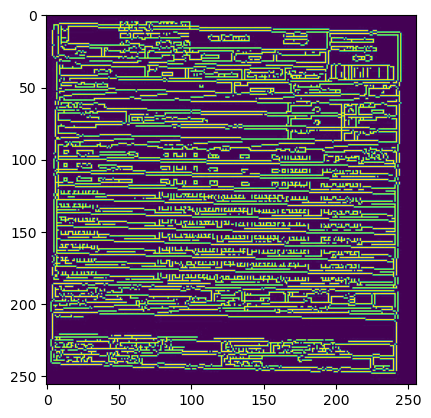

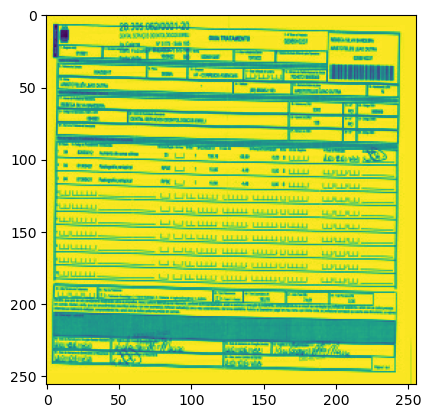

In [31]:
# teste da função carregar_Imagem 
img_original, img_transf = carregar_Imagem(PATH + 'train/3.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(img_original / 255.0)
plt.figure()
plt.imshow(img_transf / 255.0)

In [23]:
def qtdTrain():
    qtd_train = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
    return len(list(qtd_train))

In [24]:
# The facade training set consist of 400 images
BUFFER_SIZE = qtdTrain()
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [40]:
# Redimencionar as imagens para o formato correto 
def redimencionar(img_original, img_real, height, width):
    img_original = tf.image.resize(img_original, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img_real = tf.image.resize(img_real, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_original, img_real

In [41]:
def normalizar(img_original, img_transf):
    img_original = (img_original / 127.5) - 1
    img_transf = (img_transf / 127.5) - 1
    return img_original, img_transf

In [51]:
def crop_aleatorio(img_original, img_transf):
    img_empilhada = tf.stack([img_original, img_transf], axis = 0)
    img_crop = tf.image.random_crop(img_empilhada, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])
    return img_crop[0], img_crop[1]

In [52]:
@tf.function()
def jitter_aleatorio(img_original, img_transf):
    
    img_original, img_transf = redimencionar(img_original, img_transf, 256, 256)
    img_original, img_transf = crop_aleatorio(img_original, img_transf)
    if tf.random.uniform(()) > 0.5:
        img_original = tf.image.flip_left_right(img_original)
        img_transf = tf.image.flip_left_right(img_transf)
    return img_original, img_transf

In [ ]:
#Defina o upsampler (decodificador)
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

AttributeError: module 'matplotlib.pyplot' has no attribute 'imgshow'

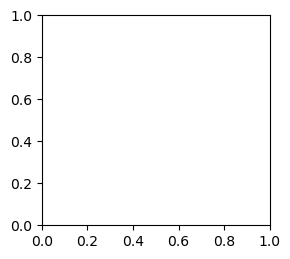

In [54]:
# teste 
plt.figure(figsize=(10,6))
for i in range(6):
    j_original, j_tranf =  jitter_aleatorio(img_original, img_transf)
    plt.subplot(2, 3, i + 1)
    plt.imgshow(j_original / 255.0)
    plt.axis('off')
plt.show()

In [50]:
img_original.shape

TensorShape([256, 256, 1])